# E-tivity 2 : Gerard O'Rourke, Student number : 24514772
This workbook is for E-tivity2.  It follows the following structure
1. The workbook environment is setup
1. The next section has some EDA related to this E-tivity
1. Each task for this E-tivity then follows

## A. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import set_config
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

print(sklearn.__version__)

# needed for changing Ordinal values - see education
pd.set_option("future.no_silent_downcasting", True)
#sklearn.set_config(enable_metadata_routing=True)
set_config(transform_output='pandas')

1.6.1


#### Define helper functions

In [2]:
# 
# Graphing helper
# 
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

In [3]:
#
# eps: Max distance between two samples to be considered neighbours
# min_samples: Minimum number of points to form a dense region
#
# called with a range of eps and min_sample values, returns results as a dataframe
#
def run_dbscan_on_range(data, eps_values, min_samples_values):
    results = []

    for eps in eps_values:
        
        for min_samples in min_samples_values:
            
            db = DBSCAN(eps=eps, min_samples=min_samples)
            
            labels = db.fit_predict(data)
            
            # Count clusters (excluding noise), which has value -1
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            # get silhouette score
            if n_clusters > 1:
                score = silhouette_score(data, labels)
            else:
                score = -1  # -1 is noise

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': score
            })

    return pd.DataFrame(results)

#### Setup Environment
Load the data and keep a copy

In [4]:
# Load the dataset
df = pd.read_csv("./bank.csv")

# keep a copy 
df_original = df

print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (2000, 17)


## B. Exploratory Data Analysis and Data Preparation¶

In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32.0,technician,single,tertiary,no,392,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39.0,technician,divorced,secondary,no,688,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59.0,retired,married,secondary,no,1035,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47.0,blue-collar,married,secondary,no,398,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54.0,retired,married,secondary,no,1004,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [6]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,20.0,student,single,NaN,no,2785,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,28.0,admin.,single,secondary,no,127,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,81.0,retired,married,primary,no,1154,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,46.0,services,married,primary,no,4343,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,40.0,entrepreneur,married,secondary,no,6403,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


In [7]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,1988.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.753018,1413.663500,13.851500,292.020500,1.909500,167.896000,2.561500
std,12.724358,3131.224213,9.712189,221.557295,1.378862,131.754126,3.400735
min,18.000000,-980.000000,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,5.000000,146.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,12.000000,236.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,23.000000,379.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,31.000000,1823.000000,11.000000,854.000000,55.000000


balance and pdays has negative values

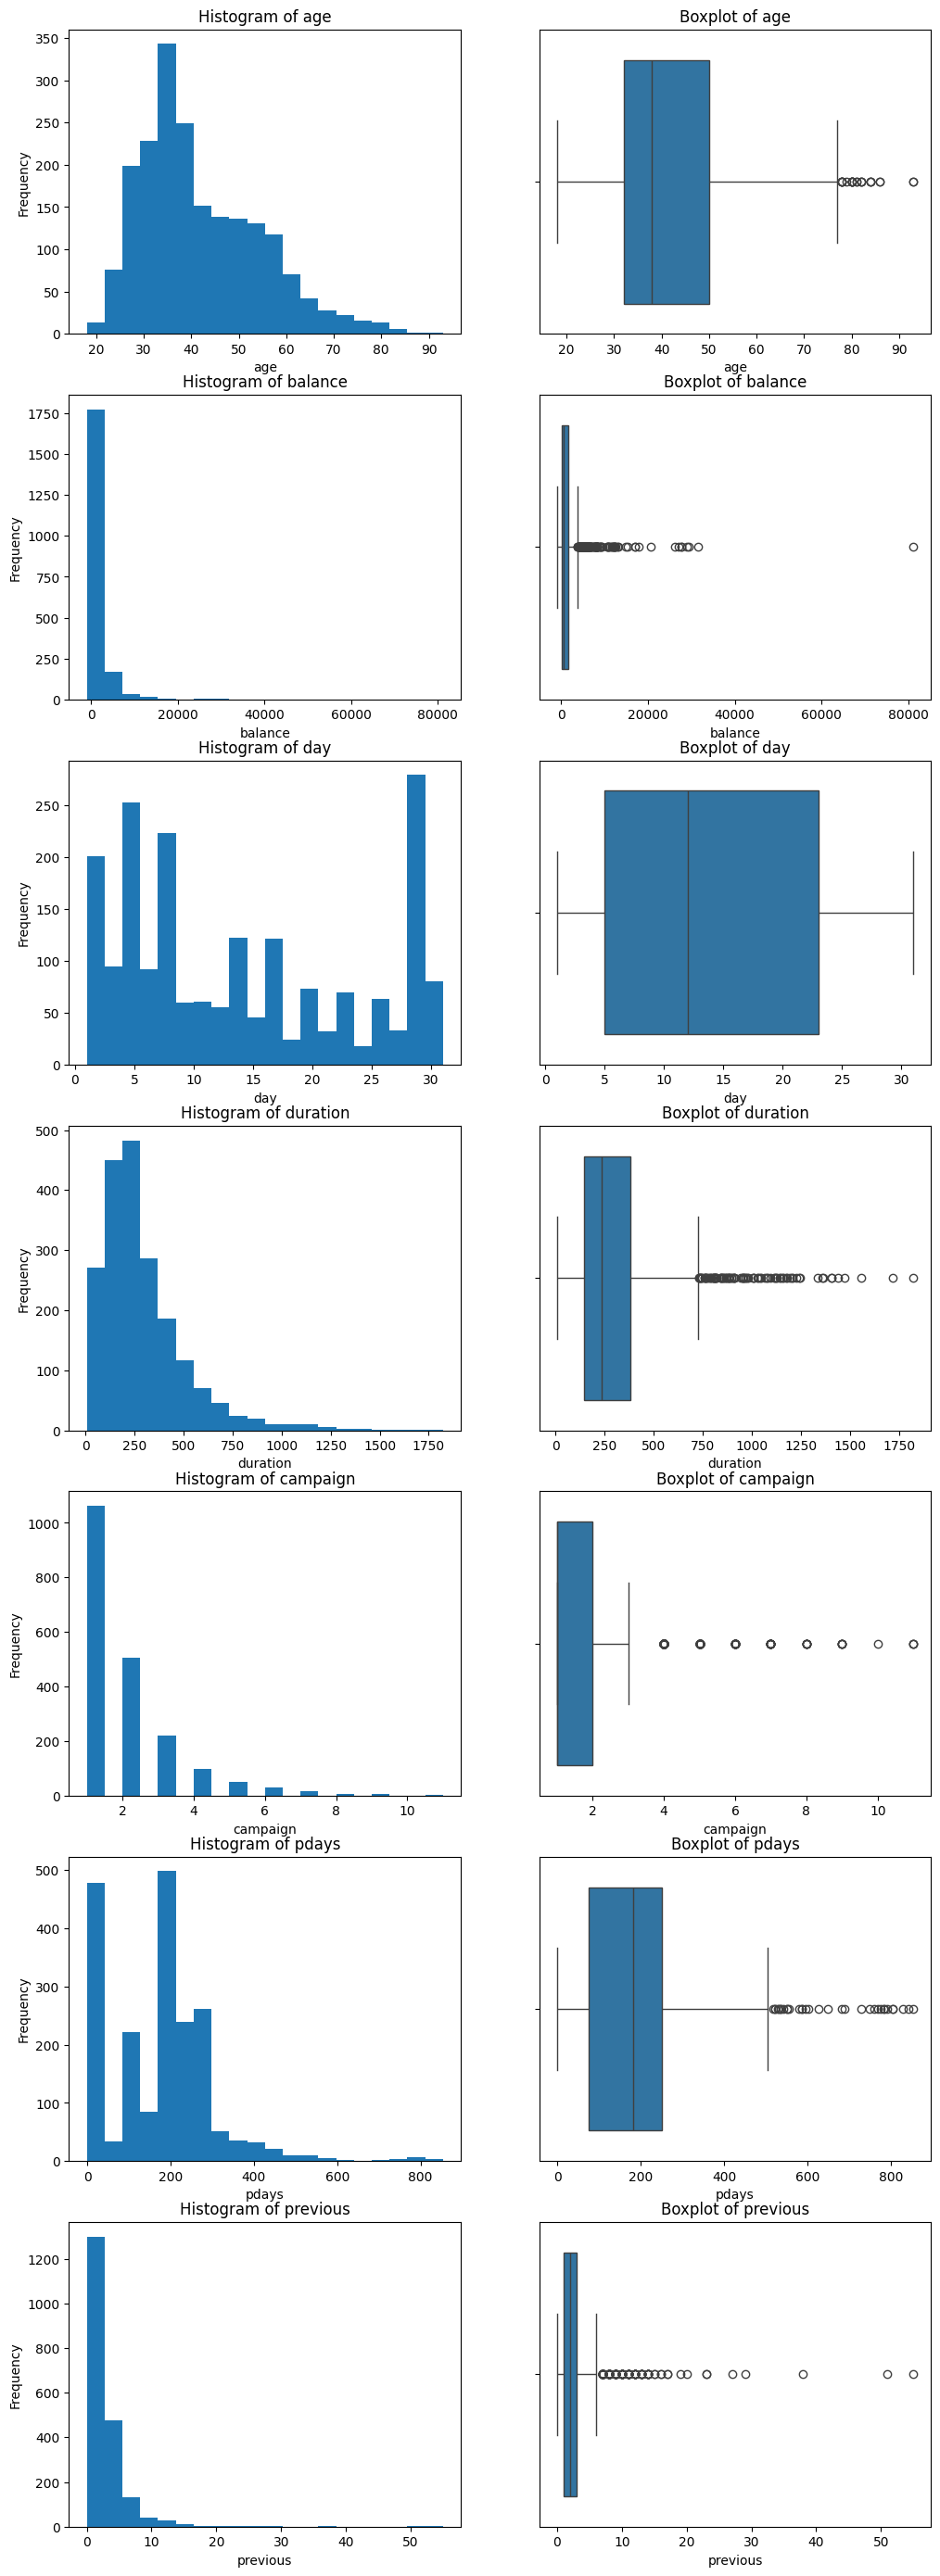

In [8]:
cols = ['age','balance','day','duration','campaign','pdays','previous']

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12,35))    

for row, column in enumerate(cols):

    axes[row,0].hist(df[column], bins=20)
    axes[row,0].set_title(f'Histogram of {column}')
    axes[row,0].set_xlabel(column)
    axes[row,0].set_ylabel('Frequency')

    # Put boxplot in 2nd col
    sns.boxplot(data=df, x=column, ax=axes[row][1])
    
    axes[row,1].set_title(f'Boxplot of {column}')
    axes[row,1].set_xlabel(column)

plt.show()


**Everything except day has outliers and seems right skewed, so**
1. Use Minmaxscaler for days as its a known range
1. Use RobustScalar for others as they've outliers

## Task 1: Preparation : Data Pipeline

#### Drop columns that we don't want to avoid data leakage

In [9]:
# Drop columns that we don't want to avoid data leakage
df.drop(columns=['duration'], inplace=True) 
df.drop(columns=['subscribed'], inplace=True) 


#### Setup Order for encoding of Education and Month for later use in pipeline
The order for Education and Month is setup here.  One comment in the forums suggested I could do a cylical encoding for month and day here, but I did not do that in the previous E-tivity, so I didn't replicate that here.

In [10]:
# Create a dictionary for education
education_order = [['primary', 'secondary', 'tertiary']]

# Create a dictionary for month
month_order = [['jan','feb','mar','apr','may','jun',
                  'jul', 'aug', 'sep', 'oct', 'nov', 'dec']]

#### Deal with Zero or negative values
The data has negative values.  Add a delta to attributes with a negative value, to make them positive, then do a log transform

In [11]:
df.describe()

,age,balance,day,campaign,pdays,previous
count,1988.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.753018,1413.663500,13.851500,1.909500,167.896000,2.561500
std,12.724358,3131.224213,9.712189,1.378862,131.754126,3.400735
min,18.000000,-980.000000,1.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,5.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,12.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,23.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,31.000000,11.000000,854.000000,55.000000


In [12]:
# get min values for attributes, add a delta and do a log transform to make the values all positive
columns = ['balance','pdays']

for col in columns:
    shift_value = abs(df[col].min()) + 2  # Ensures no negative or zero
    df[col] = np.log(df[col] + shift_value)

# make  previous > 0
df['previous'] = df['previous'] + 1

df.describe()

,age,balance,day,campaign,pdays,previous
count,1988.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.753018,7.511862,13.851500,1.909500,4.229232,3.561500
std,12.724358,0.647772,9.712189,1.378862,1.983043,3.400735
min,18.000000,0.693147,1.000000,1.000000,0.693147,1.000000
25%,32.000000,7.076231,5.000000,1.000000,4.366263,2.000000
50%,38.000000,7.334982,12.000000,1.000000,5.220356,3.000000
75%,50.000000,7.873407,23.000000,2.000000,5.537334,4.000000
max,93.000000,11.316740,31.000000,11.000000,6.753438,56.000000


#### Check for Missing Values

In [13]:
print(df.dtypes)

age          float64
job           object
marital       object
education     object
default       object
balance      float64
housing       object
loan          object
contact       object
day            int64
month         object
campaign       int64
pdays        float64
previous       int64
poutcome      object
dtype: object


In [14]:
### Check for missing values.  .sort_values(ascending=False)
print ('number of values missing for column')
df.isna().sum()[df.isna().sum() > 0].sort_index(ascending=True)



number of values missing for column


age           12
contact      191
education    104
job           10
poutcome     454
dtype: int64

#### Imput Poutcome
From the first assignment, we decided to set for poutcome to not_contacted.

In [15]:
# Looks like poutcome won't be filled out if they haven't been contacted before, which is reasonable.  For these rows, imput not_contacted
df['poutcome']=df['poutcome'].fillna('not_contacted')


### Pipeline Approach
The following modifications are made on the data outside the pipeline
    1. duration and subscribed are dropped from the dataset to avoid data leakage.
    1. Poutcome.  A value of not_contacted was inserted for null values.  Ideally this would be imputted with the SimpleInputter with the constant strategy.
    1. balance, pdays and previous.  A delta was applied to the value and a log transform was applied.  A FunctionTransformer could be used for this purpose
  
In the pipeline, Value Imputs and scaling will be applied as per the following table.

|Type| Attribute    | Imput | Scale| One Hot Encode|Comment|
|-----|-------------|-----|------------|--------|----|
|Numerical| age   | most_frequent  | Robust   |||
|Numerical| balance     |  | Robust  |||
|Numerical| campaign |   | MinMaxScalar    |||
|Categorical| contact   | most_frequent  | |Yes   ||
|Numerical| day     |   | MinMaxScaler  |||
|Categorical| default |  |  |Yes||
|Categorical-Ordinal| education   | most_frequent  |    |Yes|Uses an array (above) to define the order|
|Categorical| housing     |  |  |Yes||
|Categorical| job | most_frequent  |  |Yes||
|Categorical| loan   |   |    |Yes||
|Categorical| marital     |  |  |Yes||
|Categorical-Ordinal| month |   | MinMaxScaler    ||Uses an array (above) to define the order|
|Numerical| pdays     |   | Robust  |||
|Categorical| poutcome | Done outside pipeline  |     |Yes|Manually Imput NOT_CONTACTED for N/As above, perhaps use MissingIndicator Imputter |
|Numerical| previous |   | Robust    |||numerical_attribute_scale_using_robust

#### Pipeline Implementation

In [16]:
#
# pipeline definition.  values processed in two branches, numerical + categorical
# 
# Most frequent values are imputed if needed
# MinMax scalar applied to day, the rest use the RobustScalar
#
# Month and education are encoded using the ordinal encoder
#
numerical_attribute = ['age','balance','campaign','day','pdays','previous']
numerical_attribute_scale_using_min_max = ['day']
numerical_attribute_scale_using_robust=['age','balance','campaign','pdays','previous']

categorical_attribute = ['contact','default','education','housing','job','loan','marital','month','poutcome']

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', ColumnTransformer(
                transformers=[
                        ('scale_using_min_max',MinMaxScaler(),numerical_attribute_scale_using_min_max),
                        ('scale_using_robust',RobustScaler(),numerical_attribute_scale_using_robust)
                        ]
                )
    )
    ]
)

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', ColumnTransformer(
                transformers=[
                        ('education_order', OrdinalEncoder(categories=education_order), ['education']),
                        ('month_order', OrdinalEncoder(categories=month_order), ['month'])
                        ]
                )),
    ('one-hot',OneHotEncoder(sparse_output=False)) # sparse output required for fit_transform
])

# 
# Use a col transformer to operate on each set separately
# 
col_transform = ColumnTransformer(transformers=[
        ('num_pipeline',num_pipeline,numerical_attribute),
        ('cat_pipeline',cat_pipeline,categorical_attribute)
    ], remainder='drop', n_jobs=-1)


# create the actual pipeline
preprocess_pipeline = Pipeline(steps=[
    ('preprocess', col_transform), 
    
])

# run the pipeline
df_post_col_transform = preprocess_pipeline.fit_transform(df)




In [17]:
### Check post pipeline
df_post_col_transform.describe()

,num_pipeline__scale_using_min_max__day,num_pipeline__scale_using_robust__age,num_pipeline__scale_using_robust__balance,num_pipeline__scale_using_robust__campaign,num_pipeline__scale_using_robust__pdays,num_pipeline__scale_using_robust__previous,cat_pipeline__education_order__education_0.0,cat_pipeline__education_order__education_1.0,cat_pipeline__education_order__education_2.0,cat_pipeline__month_order__month_0.0,...,cat_pipeline__month_order__month_2.0,cat_pipeline__month_order__month_3.0,cat_pipeline__month_order__month_4.0,cat_pipeline__month_order__month_5.0,cat_pipeline__month_order__month_6.0,cat_pipeline__month_order__month_7.0,cat_pipeline__month_order__month_8.0,cat_pipeline__month_order__month_9.0,cat_pipeline__month_order__month_10.0,cat_pipeline__month_order__month_11.0
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.428383,0.207250,0.221883,0.909500,-0.846339,0.280750,0.108500,0.549500,0.342000,0.122500,...,0.035000,0.102500,0.166500,0.052000,0.083500,0.068000,0.067000,0.046500,0.034000,0.020500
std,0.323740,0.704968,0.812583,1.378862,1.693358,1.700368,0.311089,0.497668,0.474498,0.327944,...,0.183826,0.303381,0.372622,0.222083,0.276706,0.251809,0.250085,0.210618,0.181274,0.141738
min,0.000000,-1.111111,-8.331702,0.000000,-3.865870,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.133333,-0.333333,-0.324584,0.000000,-0.729326,-0.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.366667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.733333,0.666667,0.675416,1.000000,0.270674,0.500000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,3.055556,4.994829,10.000000,1.309128,26.500000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Task 2: k-Means

### Getting a value for k.
Here the Elbow and Shillouette method are used.  These both choose a value for 4 for the best value for K.

#### Elbow Method

Optimal number of clusters (k): 4


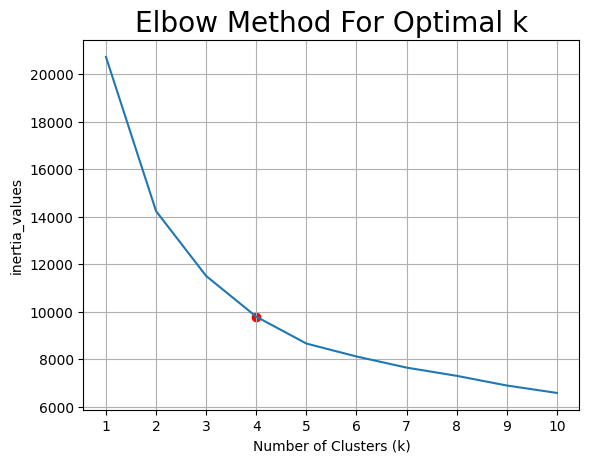

In [18]:
# Interia is the sum of the squared distance of the point and its centroid
inertia_values = []

# KMeans args
#  n_clusters : The number of clusters to form as well as the number of centroids to generate.
# ‘k-means++’ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia
# max_iter : iterations per run
# n_init : Number of times the k-means algorithm is run with different centroid seeds
# random_state : Determines random number generation for centroid initialization

#
#
# Loop through a range of k values (1 to 10 for example)
for k in range(1, 11):
 
    model = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    
    model.fit(df_post_col_transform)  # Fit the k-Means model
    
    inertia_values.append(model.inertia_)  # Inertia is the sum of squared distances

kl = KneeLocator(range(1, 11), inertia_values, curve="convex", direction="decreasing" )

print(f"Optimal number of clusters (k): {kl.elbow}")

# Plotting the Elbow Method graph
plt.plot(range(1, 11), inertia_values)
plt.xticks(range(1, 11))
plt.scatter(kl.elbow, inertia_values[kl.elbow - 1], color='red', label='Elbow')
plt.style.use("fivethirtyeight")
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('inertia_values')
plt.grid(True)
plt.show()


#### Silhouette Coefficient

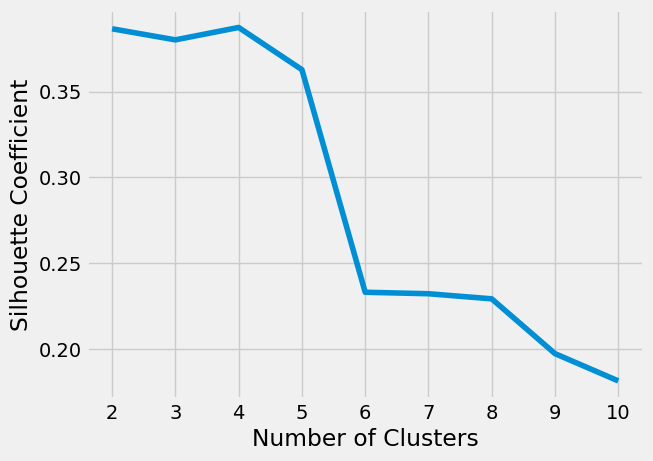

Optimal number of clusters (k) based on Silhouette Score: 4


In [19]:
silhouette_coefficients = []
 
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    
    model = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    
    model.fit(df_post_col_transform)  # Fit the k-Means model
    
    score = silhouette_score(df_post_col_transform, model.labels_)
    
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

# Print the best k with the highest silhouette score
best_k = range(2, 11)[silhouette_coefficients.index(max(silhouette_coefficients))]

print(f"Optimal number of clusters (k) based on Silhouette Score: {best_k}")

#### Elbow + Silhouette values conclusion
1. The Elbow score suggests 4 is the best k value number
1. Silhouette score suggests 4 is the best value for k.

### Graph for k = 4 with MDS and t-SNE

In [20]:
best_k = 4

model = KMeans(n_clusters=best_k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    
model.fit(df_post_col_transform)  # Fit the k-Means model

# Append the cluster centers to the preprocessed dataset.
data_and_centers = np.r_[df_post_col_transform,model.cluster_centers_]



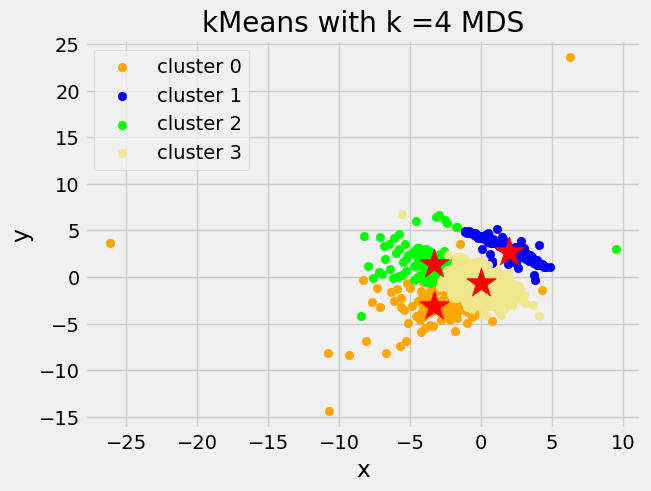

In [21]:
# Project both the data and the k-Means cluster centers to 2D.
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)

clustering_scatterplot(points=XYcoordinates[:-best_k,:], 
                       labels=model.labels_, 
                       centers=XYcoordinates[-best_k:,:], 
                       title=f'kMeans with k ={best_k} MDS')

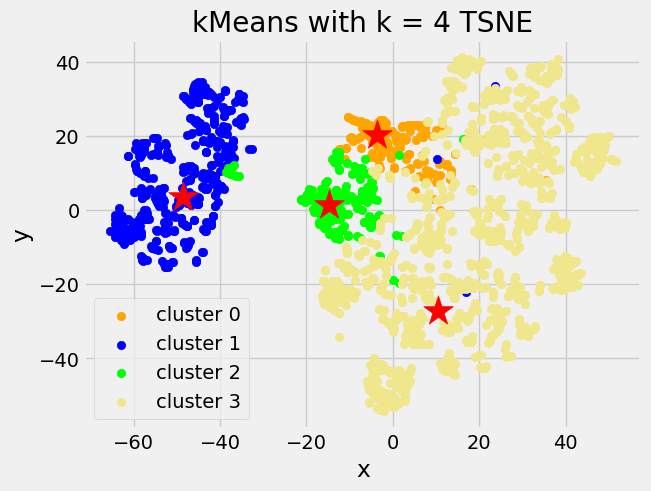

In [22]:
# 
# 
## 
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)

# convert to NumPy array - TODO - see why
XYcoordinates = np.array(XYcoordinates)

clustering_scatterplot(points=XYcoordinates[:-best_k,:], 
                       labels=model.labels_,
                       centers=XYcoordinates[-best_k:,:], 
                       title=f'kMeans with k = {best_k} TSNE')


#### Cluster Summary / Conclusion - workings

In [23]:
df_with_cluster_info = df_original.copy()

df_with_cluster_info['k_mean_4_cluster']= model.labels_

df_with_cluster_info[df_with_cluster_info['k_mean_4_cluster'] == 0].describe()

,age,balance,day,campaign,pdays,previous,k_mean_4_cluster
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.0
mean,44.278912,7.686719,15.517007,2.013605,4.991610,11.863946,0.0
std,14.804563,0.656094,9.284214,1.122536,0.686897,6.632877,0.0
min,21.000000,6.182085,1.000000,1.000000,1.386294,8.000000,0.0
25%,34.000000,7.198930,8.000000,1.000000,4.553877,9.000000,0.0
50%,40.000000,7.527794,14.000000,2.000000,5.214936,10.000000,0.0
75%,54.500000,8.134174,24.000000,3.000000,5.323010,12.500000,0.0
max,93.000000,10.263886,30.000000,7.000000,6.658011,56.000000,0.0


In [24]:
df_with_cluster_info[df_with_cluster_info['k_mean_4_cluster'] == 1].describe()

,age,balance,day,campaign,pdays,previous,k_mean_4_cluster
count,457.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.0
mean,39.277899,7.454018,12.550218,1.707424,0.720935,1.061135,1.0
std,12.950285,0.597819,7.632326,0.993188,0.199790,0.500084,0.0
min,18.000000,5.365976,1.000000,1.000000,0.693147,1.000000,1.0
25%,30.000000,7.016161,8.000000,1.000000,0.693147,1.000000,1.0
50%,36.000000,7.281729,8.000000,1.000000,0.693147,1.000000,1.0
75%,46.000000,7.753624,17.000000,2.000000,0.693147,1.000000,1.0
max,86.000000,10.238065,31.000000,5.000000,3.091042,8.000000,1.0


In [25]:
df_with_cluster_info[df_with_cluster_info['k_mean_4_cluster'] == 2].describe()

,age,balance,day,campaign,pdays,previous,k_mean_4_cluster
count,165.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.0
mean,41.800000,7.544703,12.565476,5.321429,5.105202,4.553571,2.0
std,12.186158,0.689013,9.432800,1.571915,1.044281,2.525935,0.0
min,21.000000,5.509388,1.000000,4.000000,0.693147,1.000000,2.0
25%,32.000000,7.097342,4.000000,4.000000,5.198451,3.000000,2.0
50%,39.000000,7.372396,9.000000,5.000000,5.318120,4.000000,2.0
75%,51.000000,7.903227,20.000000,6.000000,5.572132,6.000000,2.0
max,82.000000,10.387579,31.000000,11.000000,6.289716,14.000000,2.0


In [26]:
df_with_cluster_info[df_with_cluster_info['k_mean_4_cluster'] == 3].describe()

,age,balance,day,campaign,pdays,previous,k_mean_4_cluster
count,1219.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.0
mean,42.369975,7.508007,14.313773,1.505297,5.327494,3.364303,3.0
std,12.313707,0.655705,10.406509,0.685860,0.460756,1.371511,0.0
min,19.000000,0.693147,1.000000,1.000000,3.295837,2.000000,3.0
25%,33.000000,7.080026,4.000000,1.000000,5.212211,2.000000,3.0
50%,39.000000,7.333023,13.000000,1.000000,5.337538,3.000000,3.0
75%,51.000000,7.851853,26.000000,2.000000,5.585372,4.000000,3.0
max,86.000000,11.316740,31.000000,3.000000,6.753438,7.000000,3.0


### Conclusion
1.  Clusters 0-3 are have 147, 458, 168 and 1227 members respectively.
2.  Campaign:
    1. Members of cluster id = 2 have had the most contacts,followed by those in Cluster id=0, Cluster Id=1 and then Cluster Id = 3.
1. Previous:
    1. Members of cluster id = 0 seem to be the most contacted group, followed by those in cluster group ID=2, ID=3 and ID=1

## Task 3: DBSCAN
A brute force/grid search is done here to try and find the best value for EPS.  I've struggled to find a meaningful result here.  If varied the range of EPS values and sample between 0.25 and 6 and 5 and 25 respectively, I couldn't find a reasonable clustering.  Perhaps, I'm missing something in the code, but I just can't see it.  I'm guessing it's related to the scaling, but when I swapped to the StandardScalar, I didn't have a better result.  I tried using the nearest neighbour to help locate appropriate values, but tit already suggested the values I was using.  If you could point out my mistake/omission, I'd be grateful!

In [27]:
# Lets run DBScan with 15 EPS values from 0.25 to 4, min_samples of 5..15
eps_range = np.linspace(0.25, 6, num=25);

min_samples_range  = np.arange(5, 25, step =1)


results_df = run_dbscan_on_range(df_post_col_transform, eps_range, min_samples_range)

#[results_df['silhouette'] != -1]
results_df.sort_values(by='silhouette', ascending=False)


,eps,min_samples,n_clusters,n_noise,silhouette
160,2.166667,5,2,37,0.489981
141,1.927083,6,2,89,0.394277
142,1.927083,7,2,93,0.393812
145,1.927083,10,2,114,0.393361
143,1.927083,8,2,96,0.393163
...,...,...,...,...,...
260,3.364583,5,1,7,-1.000000
259,3.125000,24,1,17,-1.000000
258,3.125000,23,1,16,-1.000000
257,3.125000,22,1,15,-1.000000


### Conclusion
An eps of 2.166667 and 4 samples gave the best silhouette score.  It suggested 2 clusters.  Run + Graph DBScan with these values

In [28]:
eps = 2.166667
min_samples = 5

db = DBSCAN(eps=eps, min_samples=min_samples)

dbscan_cluster_labels = db.fit_predict(df_post_col_transform)


transformation complete


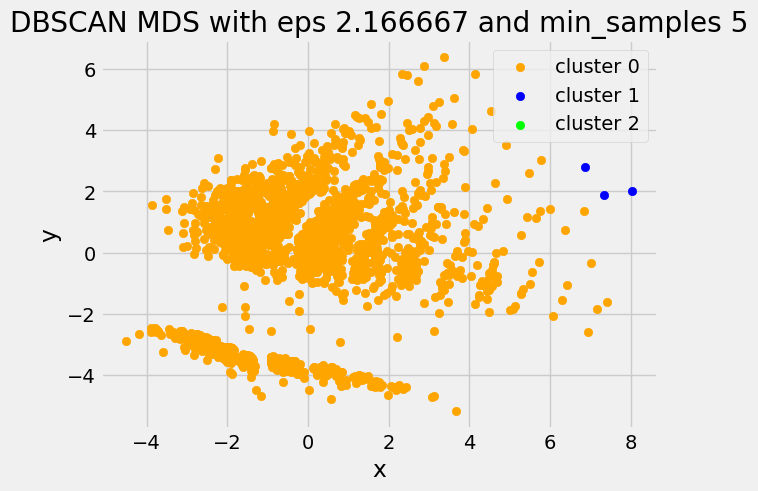

In [29]:


XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(df_post_col_transform)

print("transformation complete")

clustering_scatterplot(points=XYcoordinates, 
                       labels=dbscan_cluster_labels, 
                       centers=None, 
                       title=f'DBSCAN MDS with eps {eps} and min_samples {min_samples}')


transformation complete
(2000, 2)
<class 'pandas.core.frame.DataFrame'>


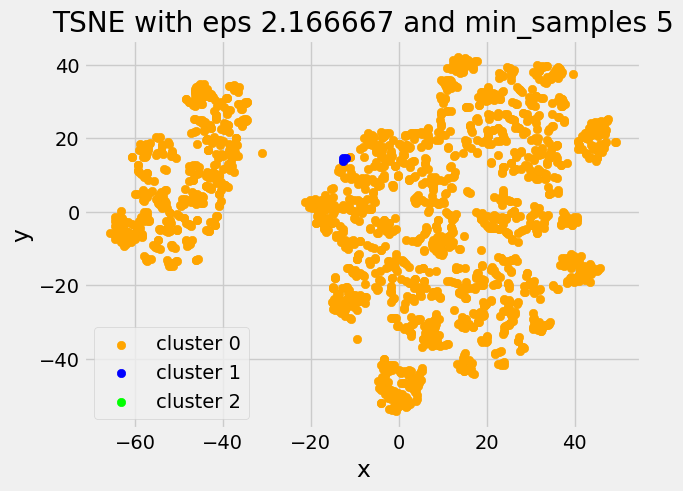

In [30]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(df_post_col_transform)
print("transformation complete")

print(XYcoordinates.shape)  
print(type(XYcoordinates))

# convert to NumPy array - TODO - see why
XYcoordinates = np.array(XYcoordinates)

clustering_scatterplot(points=XYcoordinates, 
                       labels=dbscan_cluster_labels,
                       centers=None, 
                       title=f'TSNE with eps {eps} and min_samples {min_samples}')


In [31]:
#### Cluster Summary
# Number of clusters
n_clusters = len(set(dbscan_cluster_labels)) - (1 if -1 in dbscan_cluster_labels else 0)
print(f"Number of clusters: {n_clusters}")

# Count of members in clusters
unique, counts = np.unique(dbscan_cluster_labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print(cluster_sizes)

#
df_for_analysis = df_original.copy();
df_for_analysis['cluster'] = dbscan_cluster_labels
cluster_summary = df_for_analysis.groupby('cluster').mean(numeric_only=True)
print(cluster_summary)




Number of clusters: 2
{np.int64(-1): np.int64(37), np.int64(0): np.int64(1960), np.int64(1): np.int64(3)}
               age   balance        day  campaign     pdays   previous
cluster                                                               
-1       48.916667  7.951900  13.891892  4.378378  4.275049  13.675676
 0       41.630067  7.503752  13.861735  1.855612  4.227058   3.353061
 1       35.666667  7.383303   6.666667  6.666667  5.084594  15.000000


In [32]:
df_for_analysis[df_for_analysis['cluster'] == 0].describe()

,age,balance,day,campaign,pdays,previous,cluster
count,1949.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.0
mean,41.630067,7.503752,13.861735,1.855612,4.227058,3.353061,0.0
std,12.529478,0.611243,9.718749,1.257979,1.987583,2.509978,0.0
min,18.000000,5.365976,1.000000,1.000000,0.693147,1.000000,0.0
25%,32.000000,7.073270,5.000000,1.000000,4.366263,2.000000,0.0
50%,38.000000,7.332042,12.000000,1.000000,5.220356,3.000000,0.0
75%,50.000000,7.865668,23.000000,2.000000,5.537334,4.000000,0.0
max,93.000000,10.319629,31.000000,9.000000,6.753438,17.000000,0.0


In [33]:
df_for_analysis[df_for_analysis['cluster'] == 1].describe()

,age,balance,day,campaign,pdays,previous,cluster
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.0
mean,35.666667,7.383303,6.666667,6.666667,5.084594,15.0,1.0
std,7.371115,0.358511,2.081666,0.577350,0.593162,1.0,0.0
min,30.000000,7.160846,5.000000,6.000000,4.418841,14.0,1.0
25%,31.500000,7.176514,5.500000,6.500000,4.848478,14.5,1.0
50%,33.000000,7.192182,6.000000,7.000000,5.278115,15.0,1.0
75%,38.500000,7.494531,7.500000,7.000000,5.417471,15.5,1.0
max,44.000000,7.796880,9.000000,7.000000,5.556828,16.0,1.0


### DBScan Clustering Conclusion
As such the clustering isn't of much use, as it's placed most records in cluster 0.  I'm guessing the scaling here is wrong or I've missed something in the pipeline.

1. The noise cluster (-1) has 37 members in it of the original dataset.
2. The next cluster (0) has most of the records, 1960 records.
3. The final cluster has 3 records in it.

In that cluster, one age attribute is missing and the members have been involved in around the same amount of compaigns (10/11) and have been contacted in the last 5/6 days.

Ideally you'd check to see if the results of kMeans and DBSCAN produced the same clustering by comparing at the row level, how they each classified the row, so we could get a sense of how each of the algorithms agree and disagree with each other on the row classification.

### Misc Workings

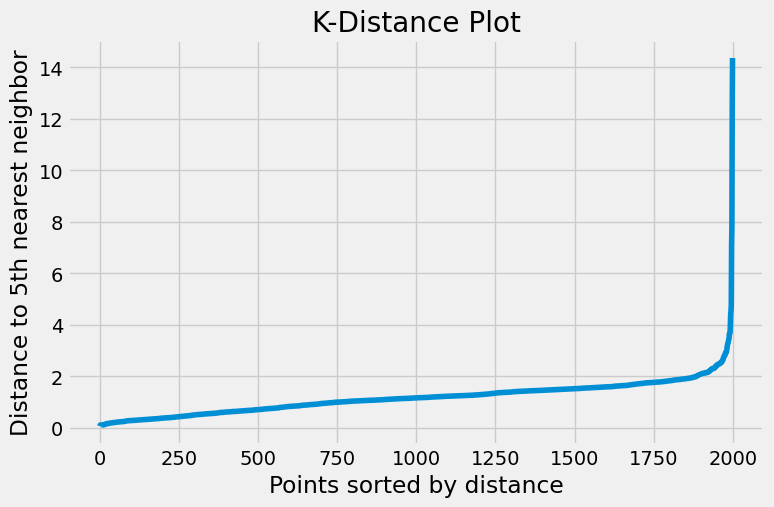

In [34]:
#
# Used to try and find a starting point for eps
#
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(df_post_col_transform)

# Compute distances to the k-th nearest neighbor for each point
distances, indices = neighbors_fit.kneighbors(df_post_col_transform)

# We want the distance to the k-th neighbor (i.e., last column)
k_distances = np.sort(distances[:, -1])

# Plot the sorted distances
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.title("K-Distance Plot")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {min_samples}th nearest neighbor")
plt.grid(True)
plt.show()

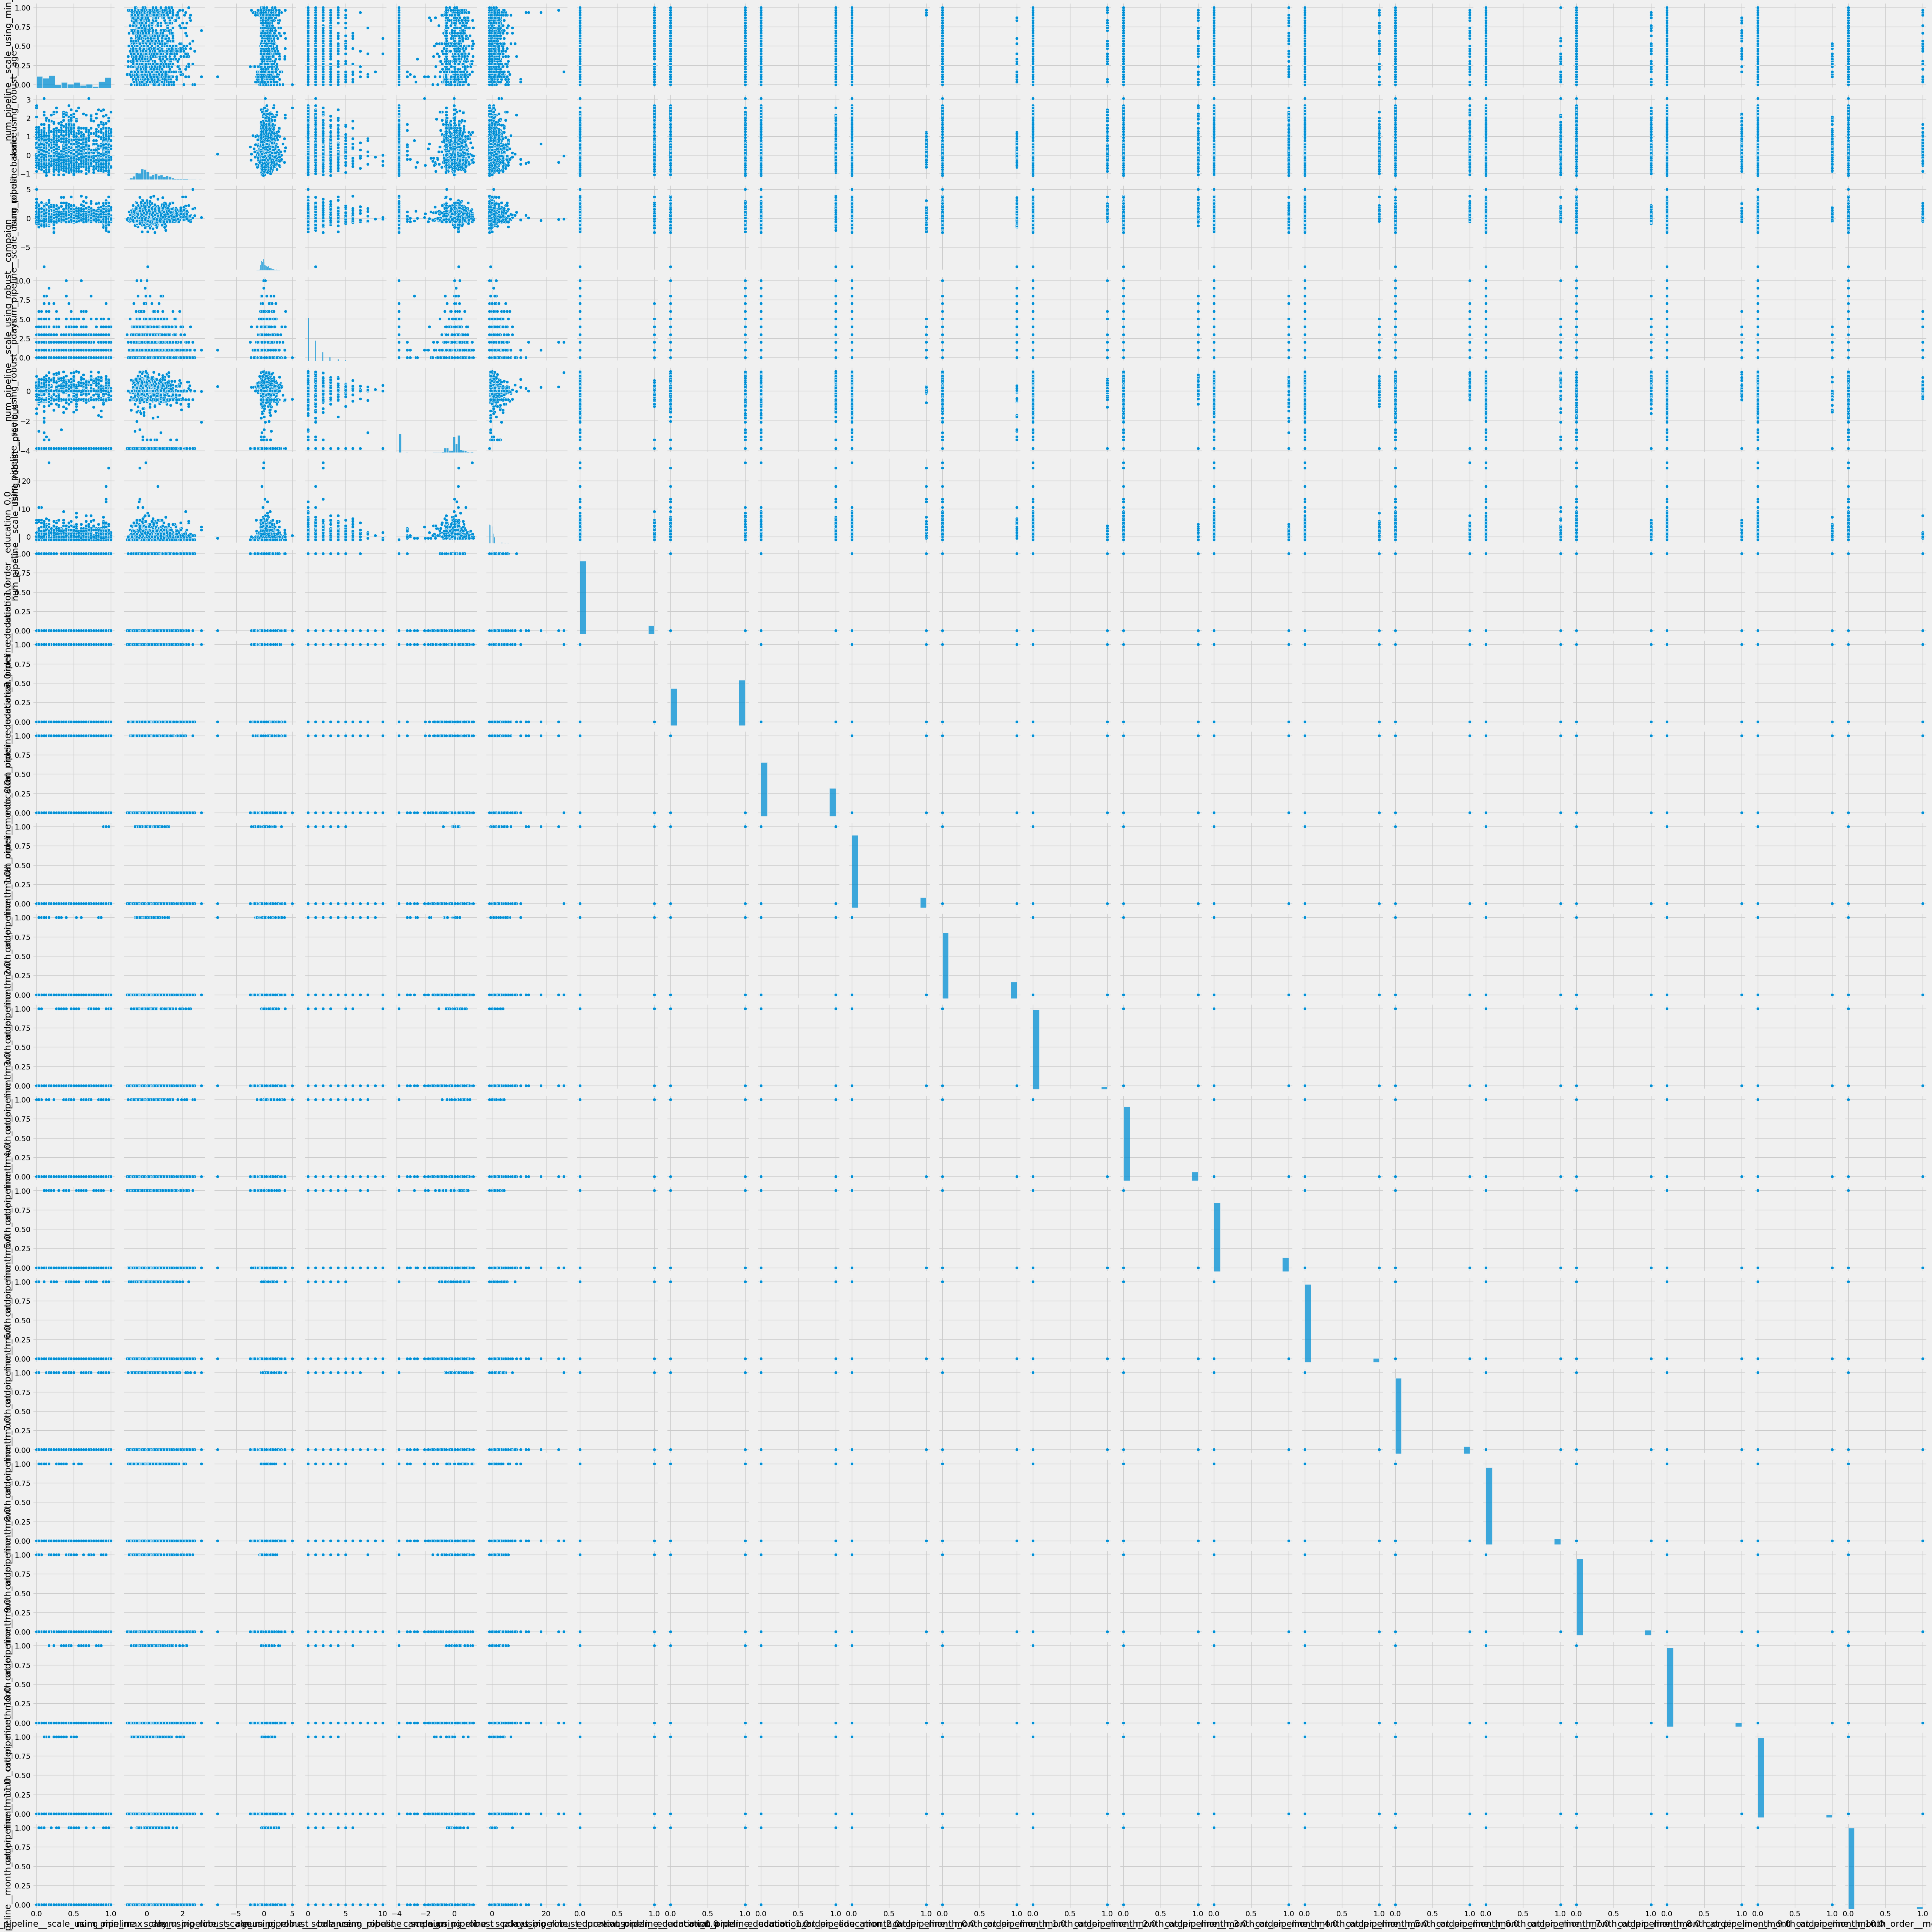

In [35]:
sns.pairplot(pd.DataFrame(df_post_col_transform, columns=df_post_col_transform.columns))
plt.show()